# Bayesian MRF for segmentation

In [1]:
import numpy as np
import cv2

Convert XYZ image to L*u*v color space

In [2]:
no_regions = 4
beta=2.5
t = 0.05 #threshold
T0 = 4.00
c = 0.98

In [3]:
def RGB2Luv(in_data):
    height = in_data.shape[0]
    width = in_data.shape[1]
    xyz_data = np.zeros([height,width,3]).astype("float64")
    luv_data = np.zeros([height,width,3]).astype("float64")
    u0 = 4 * 242.36628 / (242.36628 + 15 * 254.999745 +  3 * 277.63227)
    v0 = 9 * 254.999754 / (242.36628 + 15 * 254.999745 +  3 * 277.63227)
    #Convert into CIE-XYZ color space
    for i in range(height):
        for j in range(width):
            #X component
            xyz_data[i][j][0] = (in_data[i][j][0] * 0.412453 +
                                 in_data[i][j][1] * 0.35758 +
                                 in_data[i][j][2] * 0.180423)
            # Y component
            xyz_data[i][j][1] = (in_data[i][j][0] * 0.212671 +
                                 in_data[i][j][1] * 0.715160 +
                                 in_data[i][j][2] * 0.072169)
            # Z component
            xyz_data[i][j][2] = (in_data[i][j][0] * 0.019334 +
                                 in_data[i][j][1] * 0.119193 +
                                 in_data[i][j][2] * 0.950227)
    #Convert into CIE-L*u*v color space
    for i in range(height):
        for j in range(width):
            if ((xyz_data[i][j][1]/254.999745) > 0.008856):
                luv_data[i][j][0] = 116*np.power(xyz_data[i][j][1]/264.999745, 1/3)-16
            else:
                luv_data[i][j][0] = 903.3*(xyz_data[i][j][1]/254.999745)
            #u component
            if ((xyz_data[i][j][0] + 15 * xyz_data[i][j][1] + 3 * xyz_data[i][j][2])==0):
                luv_data[i][j][1] = 13 * luv_data[i][j][0] * (-u0)
            else:
                luv_data[i][j][1] = 13 * luv_data[i][j][0] * ((4 * xyz_data[i][j][0]/
                                                               (xyz_data[i][j][0] + 15 * xyz_data[i][j][1] + 3 * xyz_data[i][j][2])) - u0)
    
            #v component
            if ((xyz_data[i][j][0] + 15 * xyz_data[i][j][1] + 3 * xyz_data[i][j][2])==0):
                luv_data[i][j][2] = 13 * luv_data[i][j][0] * (-v0)
            else:
                luv_data[i][j][2] = 13 * luv_data[i][j][0] * ((9 * xyz_data[i][j][1] /
                                                               (xyz_data[i][j][0] + 15 * xyz_data[i][j][1] + 3 * xyz_data[i][j][2])) - v0)
    
    return luv_data

Prior Guanssian distribution parameters

In [4]:
def CalculateMeanAndCovariance(frame):
    h=frame.shape[0]
    w=frame.shape[1]
    variance = np.zeros(3).astype("float64")
    mean = np.zeros(3).astype("float64")
    covariance = np.zeros(3).astype("float64")
    invcov = np.zeros(6).astype("float64")
    for k in range(3):
        frame_LUV = np.reshape(frame[:,:,k], -1)
        mean[k] = np.mean(frame_LUV)
        variance[k] = np.var(frame_LUV,ddof=1)
    #compute covariances
    frame_L = np.reshape(frame[:,:,0], -1)
    frame_u = np.reshape(frame[:,:,1], -1)
    frame_v = np.reshape(frame[:,:,2], -1)
    mean_L = mean[0]
    mean_u = mean[1]
    mean_v = mean[2]
    covariance[0] = np.sum((frame_L - mean_L)*(frame_u - mean_u))/(w*h)
    covariance[1] = np.sum((frame_L - mean_L)*(frame_v - mean_v))/(w*h)
    covariance[2] = np.sum((frame_u - mean_u)*(frame_v - mean_v))/(w*h)

    #compute elements of inverse covariance matrix
    invcov[0] = variance[2]*variance[1]-covariance[2]*covariance[2]
    invcov[1] = covariance[1]*covariance[2]-variance[2]*covariance[0]
    invcov[2] = covariance[0]*covariance[2]-variance[1]*covariance[1]
    invcov[3] = variance[2]*variance[0]-covariance[1]*covariance[1]
    invcov[4] = covariance[0]*covariance[1]-variance[0]*covariance[2]
    invcov[5] = variance[1]*variance[0]-covariance[0]*covariance[0]

    #compute denominator
    denom =  variance[0] * variance[1] * variance[2] - \
                          variance[2] * covariance[0] * covariance[0] - \
                          variance[1] * covariance[1] * covariance[1] - \
                          variance[0] * covariance[2] * covariance[2] + \
                          covariance[0] * covariance[1] * covariance[2] * 2
    return mean, variance, covariance, invcov, denom


Get mean etc.

In [5]:
mean = np.zeros([no_regions,3]).astype("float64")
variance = np.zeros([no_regions, 3]).astype("float64")
covariance = np.zeros([no_regions, 3]).astype("float64")
invcov = np.zeros([no_regions, 6]).astype("float64")
denom = np.zeros([no_regions]).astype("float64")
img = '../input/color_18.bmp'
img = cv2.imread(img, cv2.COLOR_RGB2BGR)
img1 = img.astype('float64')
img3 = RGB2Luv(img1)
image_height, image_width = img3.shape[0], img3.shape[1]
points = np.array([[(0,0),(4,4)],[(32,0),(36,4)],[(64,64),(68,68)],[(96,96),(100,100)]])
i=0
for refPoint in points:
    frame_i = img3[refPoint[0][1]:refPoint[1][1], refPoint[0][0]:refPoint[1][0]]
    print(frame_i)
    mean[i], variance[i], covariance[i], invcov[i], denom[i] = CalculateMeanAndCovariance(frame_i)
    i+=1
mean=(mean.T)
variance=(variance.T)
covariance=(covariance.T)
invcov=(invcov.T)
denom=(denom.T)
print(mean)
print(variance)
print(covariance)
print(invcov)
print(denom)

[[[ 80.88182264 -13.37101162 -23.26132423]
  [ 75.54926929  -6.85337765 -18.9753057 ]
  [ 78.92309235  -7.63346399 -21.51656624]
  [ 78.60602432  -2.10281156 -24.71027945]]

 [[ 74.33876368   1.54983373 -26.3076912 ]
  [ 80.67709097 -20.89273836 -15.33927315]
  [ 77.88270032  -4.51172519 -26.77571749]
  [ 79.9374046   -7.4419278  -14.79663566]]

 [[ 77.98560748 -14.44588336 -18.49225225]
  [ 77.88226326  -7.97925473 -14.07374455]
  [ 75.96385184  -2.32823942 -27.64373988]
  [ 75.36806594  -8.23345706 -24.72371546]]

 [[ 77.75810562  -8.50217073 -22.96935825]
  [ 78.14099101 -10.88428665 -19.88098832]
  [ 81.46839312  -9.81610306 -10.31734453]
  [ 77.25106611   0.44297309 -21.3179925 ]]]
[[[ 60.03398449  38.02948044 -45.16434917]
  [ 62.20542173  33.22464575 -36.40914274]
  [ 66.39908602  29.65885387 -17.49288215]
  [ 62.93562704  29.12926166 -32.4418841 ]]

 [[ 61.14673843  24.9148304  -38.84286997]
  [ 66.03749812  24.08075119 -40.11408214]
  [ 62.07161027  31.96422075 -46.41205609]
 

In [6]:
def Singleton( i, j, label, image, mean, variance, covariance, invcov, denom):
    #determinate of covariance matrix
    in_image_data = image
    #print("Singleletion:", label)

    det = variance[0][label]*variance[1][label]*variance[2][label] + \
          2 * covariance[0][label]*covariance[1][label]*covariance[0][label] -\
          covariance[0][label]*covariance[0][label]*variance[2][label] - \
          covariance[1][label]*covariance[1][label]*variance[1][label] - \
          covariance[2][label]*covariance[2][label]*variance[0][label]

    gauss = ((in_image_data[i][j][0]-mean[0][label]) * invcov[0][label] + \
             (in_image_data[i][j][1]-mean[1][label]) * invcov[1][label] +\
             (in_image_data[i][j][2]-mean[2][label]) * invcov[2][label]) * (in_image_data[i][j][0]-mean[0][label]) + \
            ((in_image_data[i][j][0]-mean[0][label]) * invcov[1][label] + \
             (in_image_data[i][j][1]-mean[1][label]) * invcov[3][label] + \
             (in_image_data[i][j][2]-mean[2][label]) * invcov[4][label]) * (in_image_data[i][j][1]-mean[1][label]) +\
            ((in_image_data[i][j][0]-mean[0][label]) * invcov[2][label] + \
             (in_image_data[i][j][1]-mean[1][label]) * invcov[4][label] + \
             (in_image_data[i][j][2]-mean[2][label]) * invcov[5][label]) * (in_image_data[i][j][2]-mean[2][label])
    #print("in_image:",in_image_data[i][j], "-", mean[:,label])
    #print("gauss:",gauss)
    if(det==0):
        det = 1e-10
    elif(det < 0):
        det = -det
    if(denom[label]==0):
        denom[label]=1e-10
    return np.log(np.sqrt(2.0*np.pi*det)) + 0.5 * gauss / denom[label]

Analysis the data distrubution
The Singleletion vary with mean and variance

In [7]:
'''
singleenergy = []
for i in range(1000):
    mean = np.zeros([1,3])
    variance = np.zeros([1,3])
    covariance = np.zeros([1,3])
    invcov = np.zeros([1,6])
    denom = np.zeros([1])
    rgb_array = np.random.rand(3,3,3) * 255
    rgb_array = rgb_array.astype('uint8')
    img1 = img.astype('float32')
    img2 = cv2.cvtColor(img1, cv2.COLOR_RGB2XYZ)
    img3 = RGB2Luv(img2)
    height, width = img3.shape[0], img3.shape[1]
    mean[0], variance[0], covariance[0], invcov[0], denom[0] = CalculateMeanAndCovariance(rgb_array)
    mean=(mean.T)
    variance=(variance.T)
    covariance=(covariance.T)
    invcov=(invcov.T)
    denom=(denom.T)
    denom[denom==0]=1e-10
    singleenergy.append(Singleletion(0, 0, 0, img3, mean, variance, covariance, invcov, denom))

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
plt.plot(singleenergy)
plt.xlabel('Data', fontsize=15)
plt.ylabel('Value', fontsize=15)
plt.grid(b=True, which='major', color='DarkTurquoise', alpha=0.4, linestyle=':', linewidth=2)
plt.minorticks_on()
plt.grid(b=True, which='minor', color='beige', alpha=0.2, linestyle='-', linewidth=2)
plt.show()
'''

"\nsingleenergy = []\nfor i in range(1000):\n    mean = np.zeros([1,3])\n    variance = np.zeros([1,3])\n    covariance = np.zeros([1,3])\n    invcov = np.zeros([1,6])\n    denom = np.zeros([1])\n    rgb_array = np.random.rand(3,3,3) * 255\n    rgb_array = rgb_array.astype('uint8')\n    img1 = img.astype('float32')\n    img2 = cv2.cvtColor(img1, cv2.COLOR_RGB2XYZ)\n    img3 = RGB2Luv(img2)\n    height, width = img3.shape[0], img3.shape[1]\n    mean[0], variance[0], covariance[0], invcov[0], denom[0] = CalculateMeanAndCovariance(rgb_array)\n    mean=(mean.T)\n    variance=(variance.T)\n    covariance=(covariance.T)\n    invcov=(invcov.T)\n    denom=(denom.T)\n    denom[denom==0]=1e-10\n    singleenergy.append(Singleletion(0, 0, 0, img3, mean, variance, covariance, invcov, denom))\n\nimport numpy as np\nimport matplotlib.pyplot as plt\nimport scipy.stats as stats\nplt.plot(singleenergy)\nplt.xlabel('Data', fontsize=15)\nplt.ylabel('Value', fontsize=15)\nplt.grid(b=True, which='major', co

In [8]:
def Doubleton(i, j, label, classes,beta):
    energy = 0
    image_height, image_width = classes.shape[0], classes.shape[1]
    #print("Doubleton:", image_height, "x", image_width)
    #print("Doubleton: beta:", beta)
    #south
    if(i != image_height-1):
        if(label == classes[i+1][j]):
            energy -= beta
        else:
            energy += beta
    #east
    if(j != image_width-1):
        if(label == classes[i][j+1]):
            energy -= beta
        else:
            energy += beta
    #north
    if(i != 0):
        if(label == classes[i-1][j]):
            energy -= beta
        else:
            energy += beta
    #west
    if(i != image_height-1):
        if(label == classes[i][j-1]):
            energy -= beta
        else:
            energy += beta

    return energy

In [9]:
def LocalEnergy(i, j, label, image, classes, mean, variance, covariance, invcov, denom, beta):
    return Singleton(i,j,label,image, mean, variance, covariance, invcov, denom)+Doubleton(i,j,label,classes, beta)

In [10]:
def CalculateEnergy(image, classes, mean, variance, covariance, invcov, denom, beta):
    singletons = 0
    doubletons = 0
    global image_height, image_width
    for i in range(image_height):
        for j in range(image_width):
            k = classes[i,j]
            singletons += Singleton(i,j,k,image,mean, variance, covariance, invcov, denom)
            doubletons += Doubleton(i,j,k,classes,beta) #each doubleton is counted twice
    #print("singletons:",singletons)
    #print("doubletons:",doubletons/2)
    return singletons+(doubletons/2)

In [11]:
# initialize using Maximum Likelihood
def SetInitClasses(image, mean, variance, covariance, invcov, denom):
    singletons = 0
    global image_height, image_width, no_regions
    classes = np.zeros([image_height, image_width]).astype("uint8")
    for i in range(image_height):
        for j in range(image_width):
            classes[i][j]=0
            e=Singleton(i,j,0,image, mean, variance, covariance, invcov, denom)
            for k in range(no_regions):
                e2 = Singleton(i,j,k,image, mean, variance, covariance, invcov, denom)
                if(e2 < e):
                    e = e2
                    classes[i,j] = k
    return classes

In [12]:
InitClasses = SetInitClasses(img3, mean, variance, covariance, invcov, denom)
print(InitClasses)

[[0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


In [13]:
#gibbs sample
def gibbs(image, mean, variance, covariance, invcov, denom,beta):
    image_height, image_width = image.shape[0], image.shape[1]
    wholeEnergy = []
    wholeT = []
    Ek = np.zeros(no_regions) #local enegies
    classes = np.zeros([image_height, image_width]).astype('uint8')
    T = T0
    InitClasses = SetInitClasses(img3, mean, variance, covariance, invcov, denom)
    E_old = CalculateEnergy(image, InitClasses, mean, variance, covariance, invcov, denom,beta)
    iterNo = 0
    while True:
        summa_deltaE = 0
        for i in range(image_height):
            for j in range(image_width):
                sumE = 0
                for s in range(no_regions):
                    Ek[s] = np.exp(-LocalEnergy(i,j,s,image,classes, mean, variance, covariance, invcov, denom,beta)/T)
                    sumE +=Ek[s]
                #CDF
                z = 0
                r=np.random.uniform(size=1)
                for s in range(no_regions):
                    z +=Ek[s]/sumE
                    if(z>r):
                        classes[i][j]=s
                        break

        E = CalculateEnergy(image, classes, mean, variance, covariance, invcov, denom, beta)
        summa_deltaE += np.abs(E_old-E)
        E_old = E
        T *= c
        iterNo += 1
        wholeT.append(T)
        wholeEnergy.append(E_old)
        #print("summa_deltaE:", summa_deltaE)
        #print("T:", T)
        #print("Energy:", E)
        #print('iterNo:', iterNo)

        if (summa_deltaE < t): # stop when energy change is small
            return classes, wholeEnergy, wholeT
            break

In [14]:
classes, wholeEnergy, wholeT=gibbs(img3, mean, variance, covariance, invcov, denom, beta)

In [15]:
print(classes)

[[0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


In [16]:
def outConvert(classes):
    classes = np.reshape(classes,(128,128))
    out_image = np.zeros([128,128,3]).astype("uint8")
    for i in range(128):
        for j in range(128):
            if(classes[i][j]==0):
                out_image[i][j] = [219,182,125]#[125,182,219]
            elif(classes[i][j]==1):
                out_image[i][j] = [112,42,156]#[156, 42,112]
            elif(classes[i][j]==2):
                out_image[i][j] = [208,6,204]#[204,  6,208]
            elif(classes[i][j]==3):
                out_image[i][j] = [81,145,30]#[ 30,145, 81]
            else:
                out_image[i][j] = [ 0,0,255]
                
    return out_image

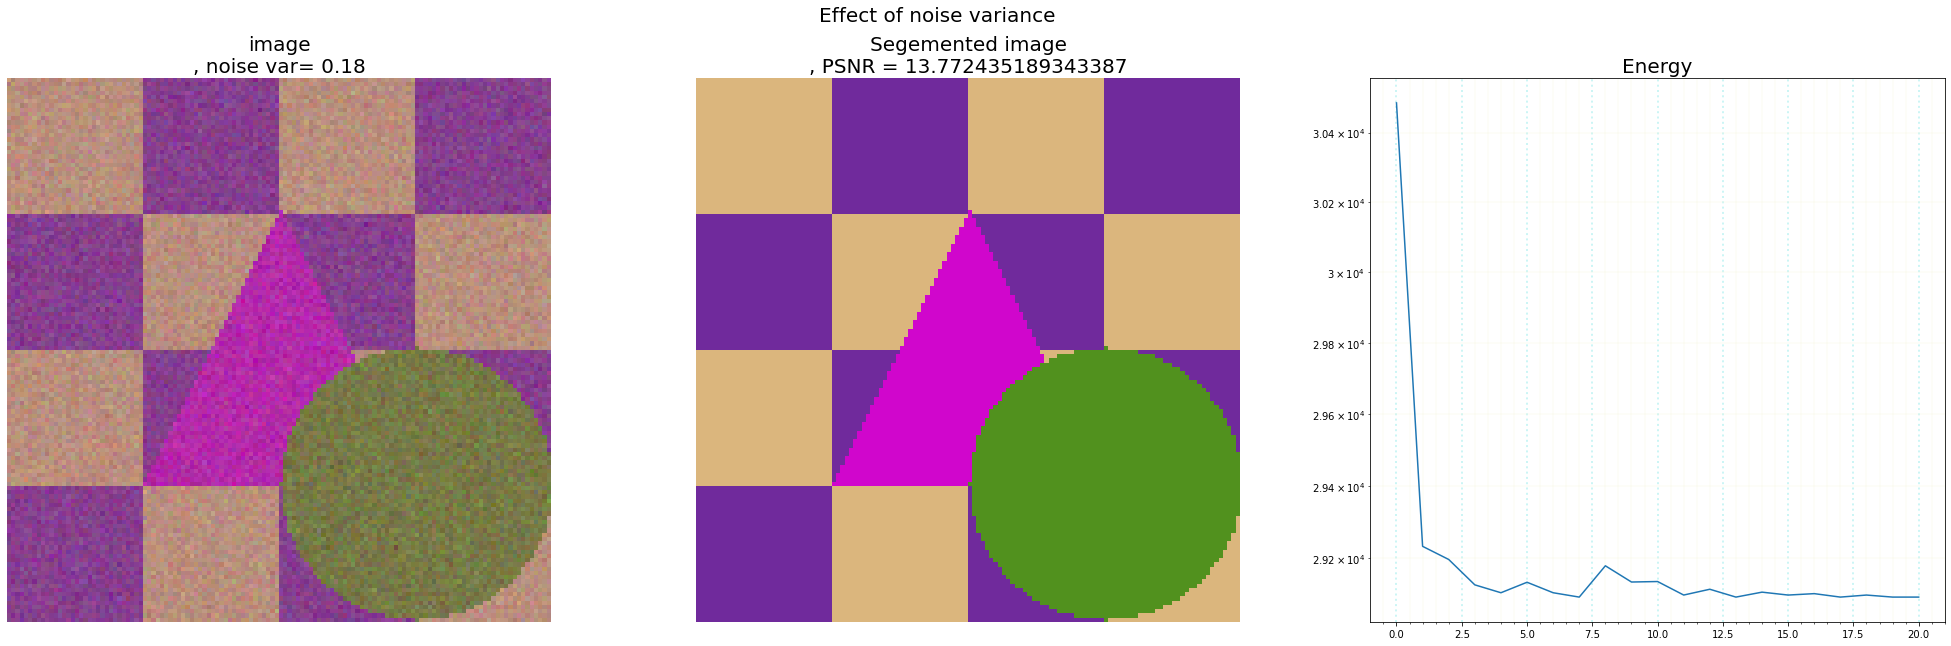

In [17]:
from PIL import Image
import random
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.ticker import LogLocator 

out_image = outConvert(classes)
fig, axs = plt.subplots(1,3, figsize=(35,10))
fig.suptitle("Effect of noise variance", fontsize=20)
noises = 18
img = '../input/color_18.bmp'
img = cv2.imread(img)
psnr = cv2.PSNR(img, out_image.astype('uint8'))
axs[0].imshow(mpimg.imread("../input/color_" + str(noises) + ".bmp"))
axs[0].axis("off")
axs[0].set_title('image\n'+', noise var= 0.'+str(noises), fontsize=20)
axs[1].imshow(out_image)
axs[1].axis("off")
axs[1].set_title('Segemented image\n' + ', PSNR = '+str(psnr), fontsize=20)
#plt.show()
plt.plot(wholeEnergy)
plt.yscale('log') 
axs[2].yaxis.set_major_locator(LogLocator(base = 10000)) 
axs[2].set_title('Energy', fontsize=20)
axs[2].grid(b=True, which='major', color='DarkTurquoise', alpha=0.2, linestyle=':', linewidth=2)
axs[2].minorticks_on()
axs[2].grid(b=True, which='minor', color='beige', alpha=0.2, linestyle='-', linewidth=2)
plt.show()

## Noise variance

In [18]:
import time
noises = [18, 26, 33, 59, 105]
OutImageList = []
WholeEnergyList = []
WholeTList = []
PSNRList = []
RunTime = []
for k in range(len(noises)):
    start_time = time.time()
    
    mean = np.zeros([no_regions,3]).astype("float64")
    variance = np.zeros([no_regions, 3]).astype("float64")
    covariance = np.zeros([no_regions, 3]).astype("float64")
    invcov = np.zeros([no_regions, 6]).astype("float64")
    denom = np.zeros([no_regions]).astype("float64")
    
    img = '../input/color_'+str(noises[k])+'.bmp'
    print(img)
    OriImg = cv2.imread(img)
    img = cv2.cvtColor(OriImg, cv2.COLOR_RGB2BGR)
    img1 = img.astype('float64')
    img3 = RGB2Luv(img1)
    points = np.array([[(0,0),(4,4)],[(32,0),(36,4)],[(64,64),(68,68)],[(96,96),(100,100)]])
    i=0
    for refPoint in points:
        frame_i = img3[refPoint[0][1]:refPoint[1][1], refPoint[0][0]:refPoint[1][0]]
        mean[i], variance[i], covariance[i], invcov[i], denom[i] = CalculateMeanAndCovariance(frame_i)
        i+=1
    mean=(mean.T)
    variance=(variance.T)
    covariance=(covariance.T)
    invcov=(invcov.T)
    denom=(denom.T)
    classes, wholeEnergy, wholeT=gibbs(img3, mean, variance, covariance, invcov, denom, beta)
    timespent=(time.time()-start_time)/len(wholeEnergy)
    print(["PSNR:"+str(psnr)])
    print(["Average time:"+str(timespent)])
    OutImage=outConvert(classes)
    psnr = cv2.PSNR(OriImg, OutImage.astype('uint8'))
    PSNRList.append(psnr)
    OutImageList.append(OutImage)
    WholeEnergyList.append(wholeEnergy)
    WholeTList.append(wholeT)
    

../input/color_18.bmp
['PSNR:13.772435189343387']
['Average time:2.8113490083943242']
../input/color_26.bmp
['PSNR:13.772435189343387']
['Average time:2.477332191589551']
../input/color_33.bmp
['PSNR:13.609975888225478']
['Average time:2.5880762471093073']
../input/color_59.bmp
['PSNR:13.425985945590133']
['Average time:2.470055298632886']
../input/color_105.bmp
['PSNR:12.48540372328778']
['Average time:2.4300050956862314']


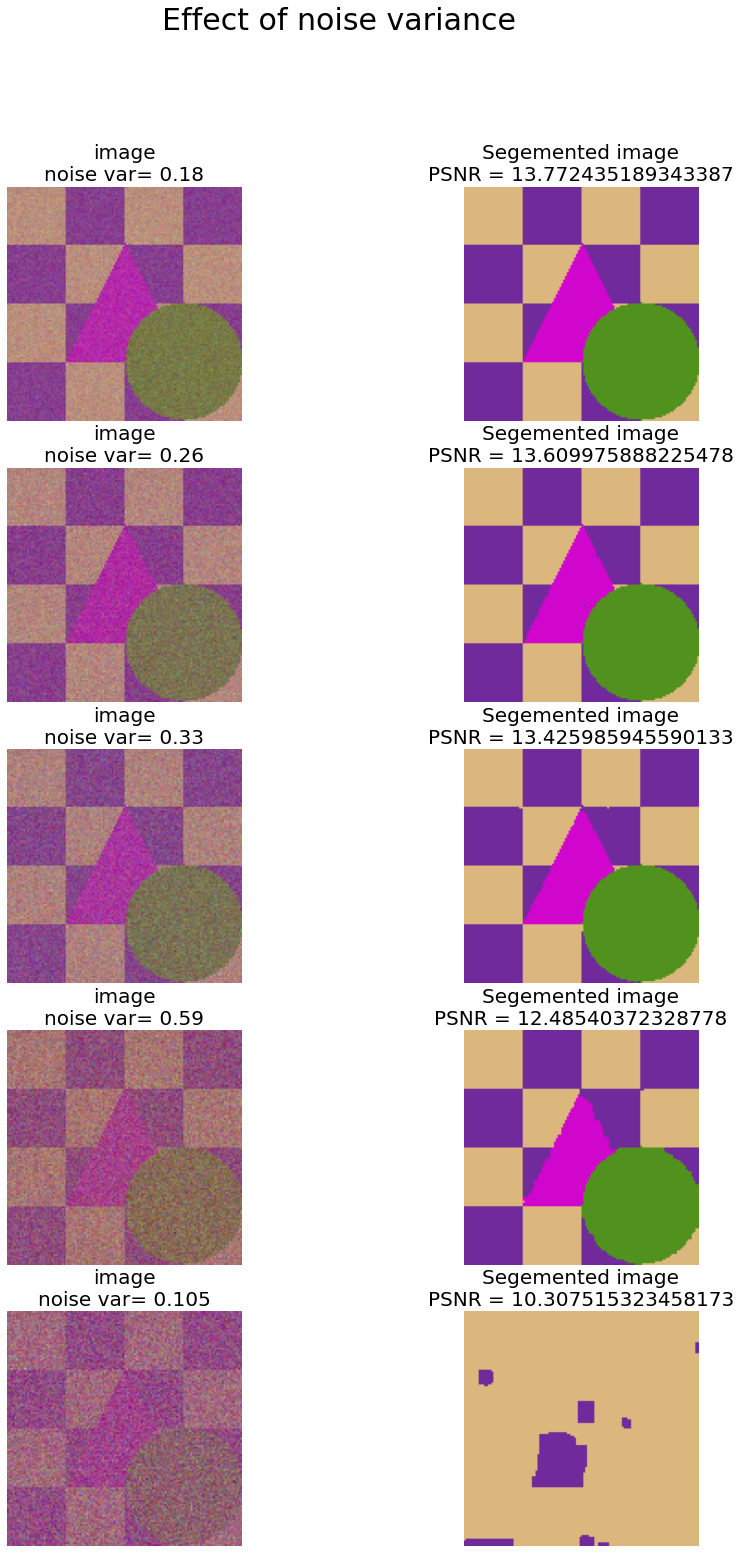

In [19]:
fig, axs = plt.subplots(len(noises),2, figsize=(15,5*len(noises)))
fig.suptitle("Effect of noise variance", fontsize=30)
for i in range(len(noises)):
    img = '../input/color_'+str(noises[i])+'.bmp'
    psnr = PSNRList[i]
    axs[i][0].imshow(mpimg.imread(img))
    axs[i][0].axis("off")
    axs[i][0].set_title('image\n'+'noise var= 0.'+str(noises[i]), fontsize=20)
    axs[i][1].imshow(OutImageList[i])
    axs[i][1].axis("off")
    axs[i][1].set_title('Segemented image\n' + 'PSNR = '+str(psnr), fontsize=20)
#plt.tight_layout()
plt.show()

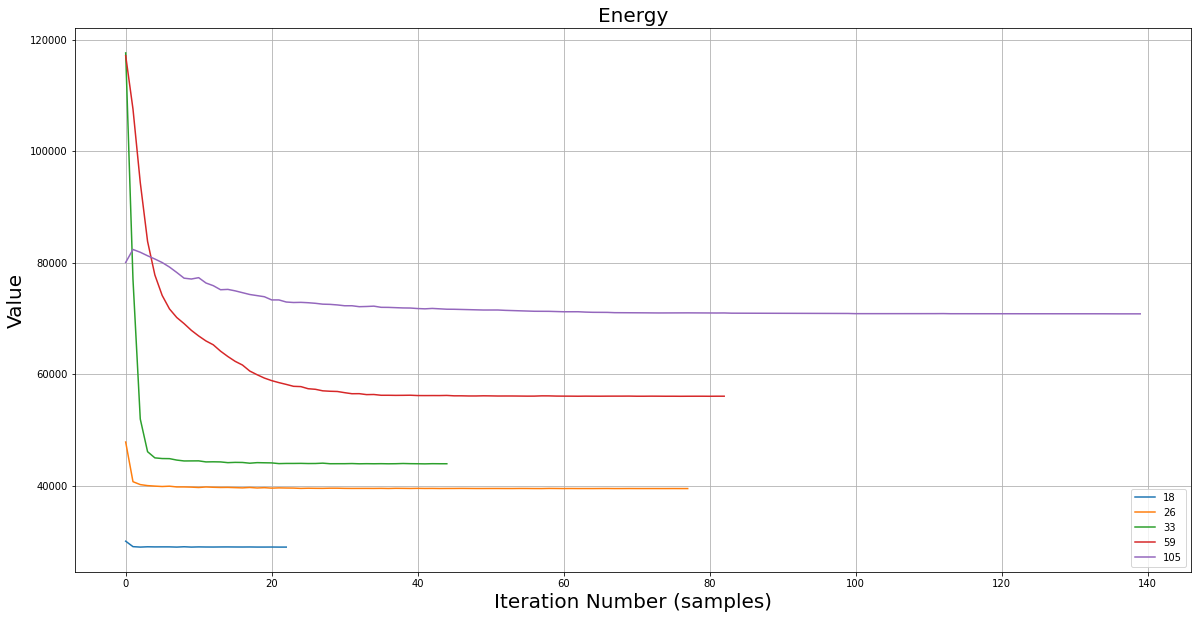

In [20]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title('Energy', fontsize=20)
ax1.set_xlabel("Iteration Number (samples)", fontsize=20)
ax1.set_ylabel("Value",fontsize=20)

for i in range(len(noises)):
    ax1.plot(WholeEnergyList[i], label=str(noises[i]))
ax1.legend(loc=4)
ax1.grid()
plt.show()
fig.savefig("energy_noise_4_labels.png")

## Beta Experiments

In [21]:
Betanoises = [33]
BetaOutImageList = []
BetaWholeEnergyList = []
BetaWholeTList = []
BetaPSNRList = []
BetaRunTime = []
bs = [0.1, 0.5, 1, 5, 7, 10, 15]
for k in range(len(bs)):
    start_time = time.time()
    
    mean = np.zeros([no_regions,3]).astype("float64")
    variance = np.zeros([no_regions, 3]).astype("float64")
    covariance = np.zeros([no_regions, 3]).astype("float64")
    invcov = np.zeros([no_regions, 6]).astype("float64")
    denom = np.zeros([no_regions]).astype("float64")
    
    img = '../input/color_'+str(Betanoises[0])+'.bmp'
    print(img)
    OriImg = cv2.imread(img)
    img = cv2.cvtColor(OriImg, cv2.COLOR_RGB2BGR)
    img1 = img.astype('float64')
    img3 = RGB2Luv(img1)
    points = np.array([[(0,0),(4,4)],[(32,0),(36,4)],[(64,64),(68,68)],[(96,96),(100,100)]])
    i=0
    for refPoint in points:
        frame_i = img3[refPoint[0][1]:refPoint[1][1], refPoint[0][0]:refPoint[1][0]]
        mean[i], variance[i], covariance[i], invcov[i], denom[i] = CalculateMeanAndCovariance(frame_i)
        i+=1
    mean=(mean.T)
    variance=(variance.T)
    covariance=(covariance.T)
    invcov=(invcov.T)
    denom=(denom.T)
    classes, wholeEnergy, wholeT=gibbs(img3, mean, variance, covariance, invcov, denom, bs[k])
    timespent=(time.time()-start_time)/len(wholeEnergy)
    print(["PSNR:"+str(psnr)])
    print(["Average time:"+str(timespent)])
    OutImage=outConvert(classes)
    psnr = cv2.PSNR(OriImg, OutImage.astype('uint8'))
    BetaPSNRList.append(psnr)
    BetaOutImageList.append(OutImage)
    BetaWholeEnergyList.append(wholeEnergy)
    BetaWholeTList.append(wholeT)
    

../input/color_33.bmp
['PSNR:10.307515323458173']
['Average time:2.519872845514961']
../input/color_33.bmp
['PSNR:13.403549984166494']
['Average time:2.8064974856514464']
../input/color_33.bmp
['PSNR:13.42685235504414']
['Average time:2.497302332143674']
../input/color_33.bmp
['PSNR:13.429311413104092']
['Average time:2.453595094382763']
../input/color_33.bmp
['PSNR:10.824977351373086']
['Average time:2.7490637642996654']
../input/color_33.bmp
['PSNR:10.165559101310413']
['Average time:3.558287501335144']
../input/color_33.bmp
['PSNR:10.165303802713455']
['Average time:3.4784854650497437']


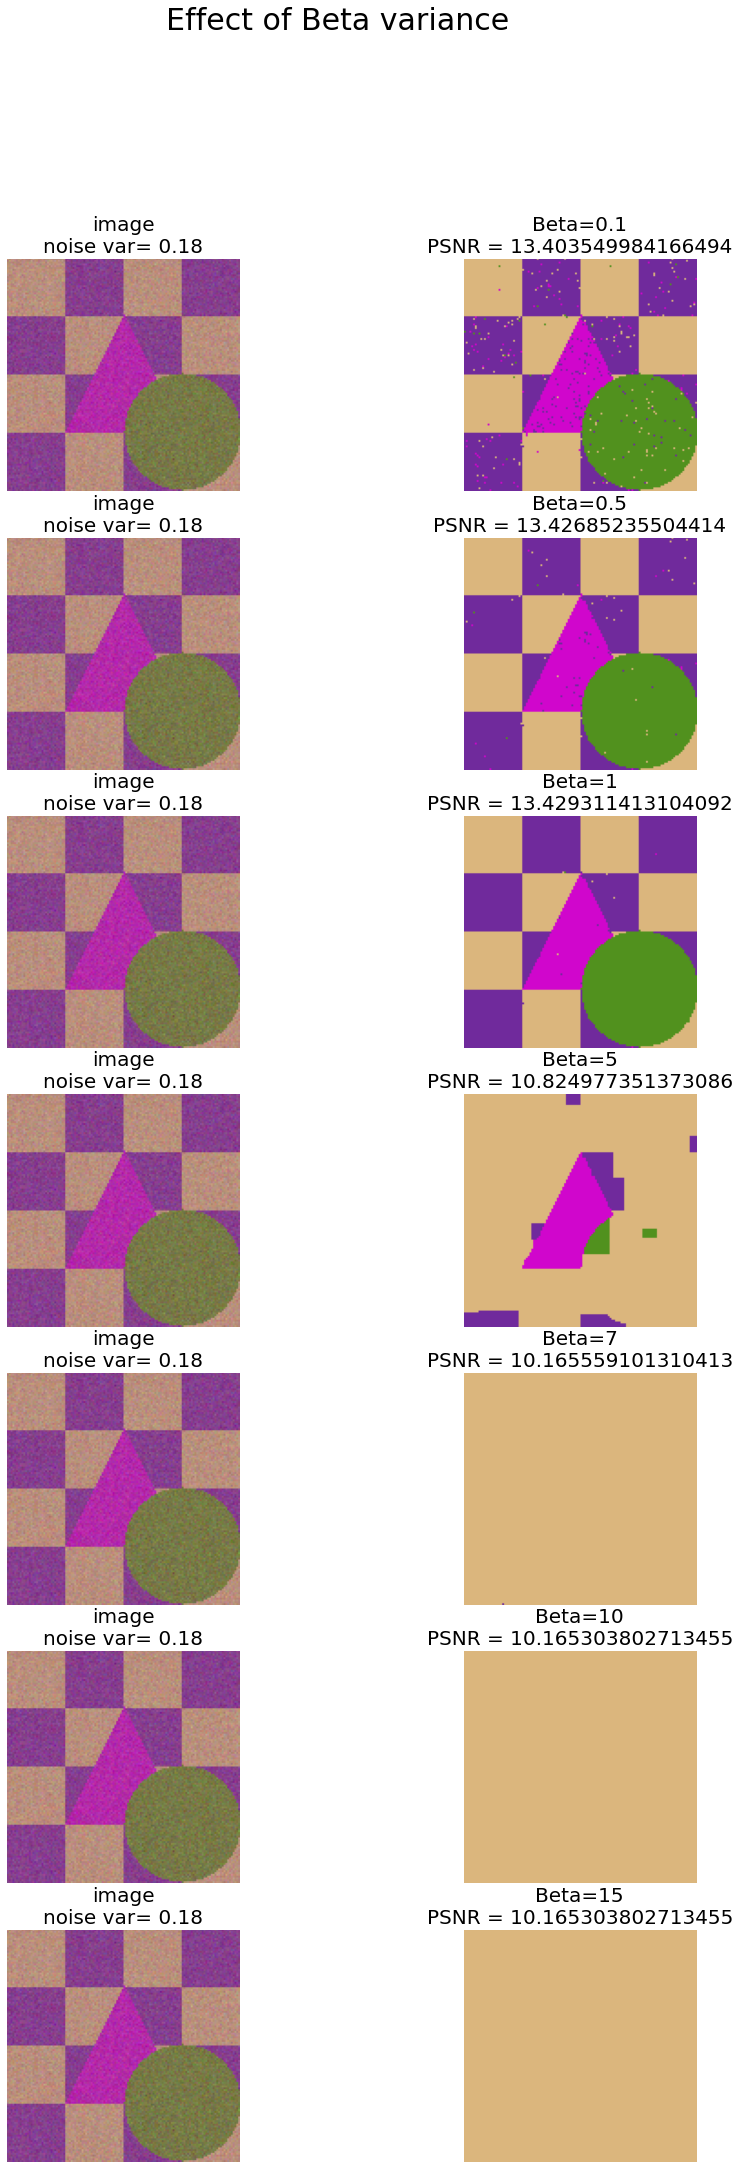

In [22]:
fig, axs = plt.subplots(len(bs),2, figsize=(15,5*len(bs)))
fig.suptitle("Effect of Beta variance", fontsize=30)
for i in range(len(bs)):
    img = '../input/color_'+str(noises[0])+'.bmp'
    psnr = BetaPSNRList[i]
    axs[i][0].imshow(mpimg.imread(img))
    axs[i][0].axis("off")
    axs[i][0].set_title('image\n'+'noise var= 0.'+str(noises[0]), fontsize=20)
    axs[i][1].imshow(BetaOutImageList[i])
    axs[i][1].axis("off")
    axs[i][1].set_title('Beta='+str(bs[i])+'\n' + 'PSNR = '+str(psnr), fontsize=20)
#plt.tight_layout()
plt.show()

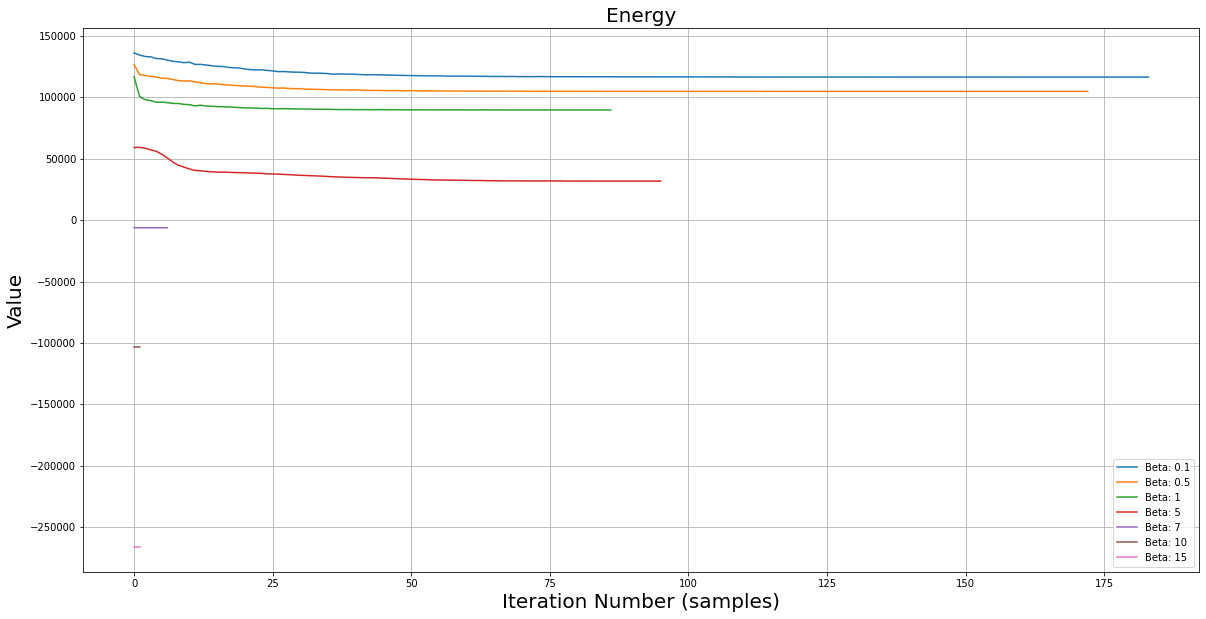

In [23]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title('Energy', fontsize=20)
ax1.set_xlabel("Iteration Number (samples)", fontsize=20)
ax1.set_ylabel("Value",fontsize=20)

for i in range(len(bs)):
    plt.plot(BetaWholeEnergyList[i], label="Beta: "+str(bs[i]))
ax1.legend(loc=4)
ax1.grid()
plt.show()
fig.savefig("energy_beta_4_labels.png")

## Training Pixel Number

In [24]:
InitNoises = [33]
InitOutImageList = []
InitWholeEnergyList = []
InitWholeTList = []
InitPSNRList = []
InitRunTime = []
InitBeta = 2.5
t = 0.05 #threshold
T0 = 4.00
c = 0.98
InitNum = [(2,2),(4,4),(8,8), (16,16)] #pixel number: 4, 16, 64, 128, 256, 512
for k in range(len(InitNum)):
    start_time = time.time()
    
    mean = np.zeros([no_regions,3]).astype("float64")
    variance = np.zeros([no_regions, 3]).astype("float64")
    covariance = np.zeros([no_regions, 3]).astype("float64")
    invcov = np.zeros([no_regions, 6]).astype("float64")
    denom = np.zeros([no_regions]).astype("float64")
    #Training Pixel
    img = '../input/color_'+str(InitNoises[0])+'.bmp'
    print(img)
    OriImg = cv2.imread(img)
    img = cv2.cvtColor(OriImg, cv2.COLOR_RGB2BGR)
    img1 = img.astype('float64')
    img3 = RGB2Luv(img1)
    points = np.array([[(0,   0), tuple(map(sum, zip((0,   0), InitNum[k])))], \
                       [(32,  0), tuple(map(sum, zip((32,  0), InitNum[k])))], \
                       [(64, 48), tuple(map(sum, zip((64, 48), InitNum[k])))], \
                       [(80, 80), tuple(map(sum, zip((80, 80), InitNum[k])))]])
    i=0
    for refPoint in points:
        frame_i = img3[refPoint[0][1]:refPoint[1][1], refPoint[0][0]:refPoint[1][0]]
        mean[i], variance[i], covariance[i], invcov[i], denom[i] = CalculateMeanAndCovariance(frame_i)
        i+=1
    mean=(mean.T)
    variance=(variance.T)
    covariance=(covariance.T)
    invcov=(invcov.T)
    denom=(denom.T)
    print(mean)
    #Inference
    classes, wholeEnergy, wholeT=gibbs(img3, mean, variance, covariance, invcov, denom, InitBeta)
    timespent=(time.time()-start_time)/len(wholeEnergy)
    print(["PSNR:"+str(psnr)])
    print(["Average time:"+str(timespent)])
    OutImage=outConvert(classes)
    psnr = cv2.PSNR(OriImg, OutImage.astype('uint8'))
    InitPSNRList.append(psnr)
    InitOutImageList.append(OutImage)
    InitWholeEnergyList.append(wholeEnergy)
    InitWholeTList.append(wholeT)


../input/color_33.bmp
[[ 77.05246311  63.80107661  62.09593909  72.5300835 ]
 [ 15.93530267  29.18525251  42.51046972   1.77073716]
 [ 10.09818431 -31.68410634 -54.86458024  19.16296349]]
['PSNR:10.165303802713455']
['Average time:2.5293624777542916']
../input/color_33.bmp
[[ 77.12877157  64.43431011  63.05072199  71.99055394]
 [ 15.71425466  23.39806512  42.1476062    3.68901061]
 [  6.12940243 -30.55067047 -50.80453288  20.2468424 ]]
['PSNR:10.719122309907508']
['Average time:2.537415918314232']
../input/color_33.bmp
[[ 77.042811    64.15923104  63.54409482  71.68125126]
 [ 16.63355638  24.90870252  41.58107729   3.92835619]
 [  5.95708114 -32.16937796 -49.32095428  19.31704715]]
['PSNR:13.427643065628939']
['Average time:2.565462655940298']
../input/color_33.bmp
[[ 77.15891785  64.09864066  63.767193    71.54266923]
 [ 16.54559333  24.18806094  38.47509144   3.78013402]
 [  5.46503261 -33.37232115 -46.3461484   17.34366609]]
['PSNR:13.428572226834678']
['Average time:2.4902195863131

In [25]:
print(InitPSNRList)

[10.719122309907508, 13.427643065628939, 13.428572226834678, 13.373955054289933]


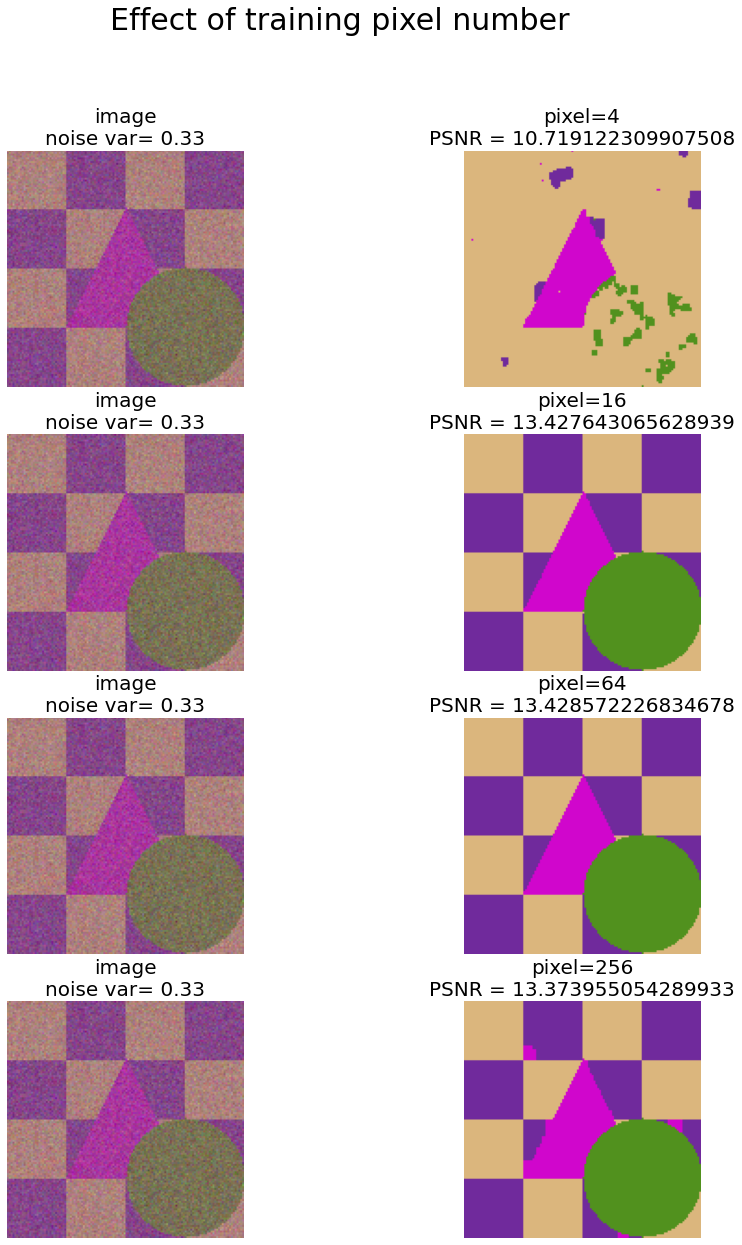

In [26]:
fig, axs = plt.subplots(len(InitNum),2, figsize=(15,5*len(InitNum)))
fig.suptitle("Effect of training pixel number", fontsize=30)
for i in range(len(InitNum)):
    img = '../input/color_'+str(InitNoises[0])+'.bmp'
    psnr = InitPSNRList[i]
    axs[i][0].imshow(mpimg.imread(img))
    axs[i][0].axis("off")
    axs[i][0].set_title('image\n'+'noise var= 0.'+str(InitNoises[0]), fontsize=20)
    axs[i][1].imshow(InitOutImageList[i])
    axs[i][1].axis("off")
    axs[i][1].set_title('pixel='+str((InitNum[i][0])*(InitNum[i][1]))+'\n' + 'PSNR = '+str(psnr), fontsize=20)
#plt.tight_layout()
plt.show()

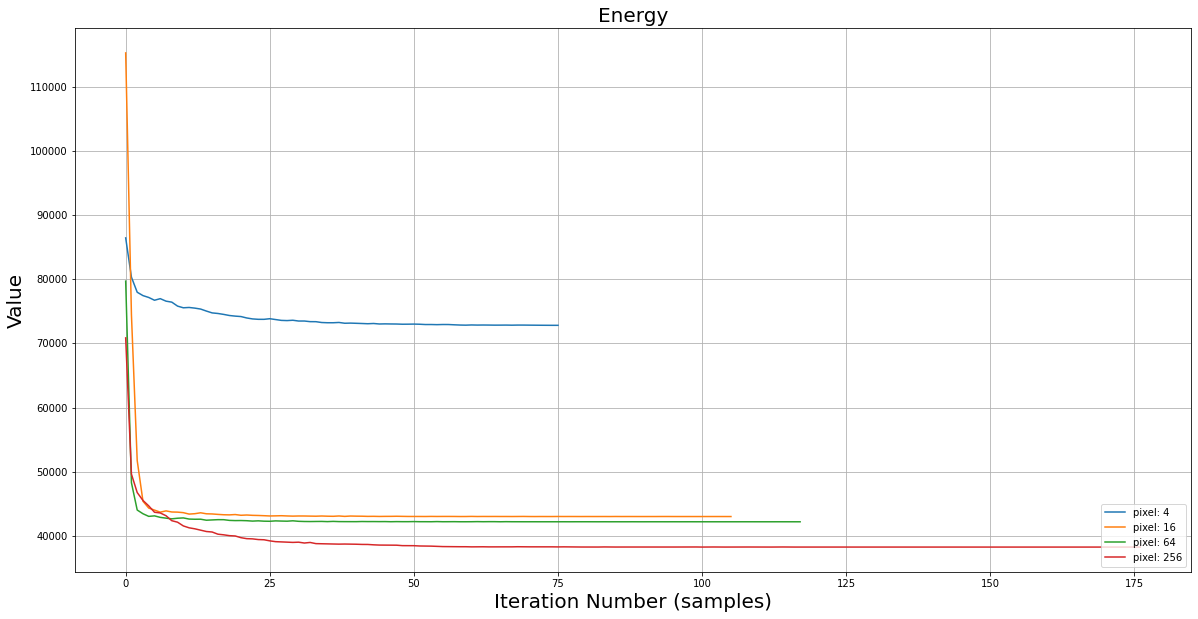

In [27]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title('Energy', fontsize=20)
ax1.set_xlabel("Iteration Number (samples)", fontsize=20)
ax1.set_ylabel("Value",fontsize=20)

for i in range(len(InitNum)):
    plt.plot(InitWholeEnergyList[i], label="pixel: "+str((InitNum[i][0])*(InitNum[i][1])))
ax1.legend(loc=4)
ax1.grid()
plt.show()
fig.savefig("energy_trainingPixel_4_labels.png")